## Capstone 3

###NJ Transit + Amtrak (NEC) Rail Performance Dataset

####NJ Transit is the second largest commuter rail network in the United States by ridership; it spans New Jersey and connects the state to New York City. On the Northeast Corridor, the busiest passenger rail line in the United States, Amtrak also operates passenger rail service; together, NJ Transit and Amtrak operate nearly 750 trains across the NJ Transit rail network.

####This dataset contains monthly CSV covering the performance of nearly every train trip on the NJ Transit rail network. The dataset has features such as Stop-level, minute resolution data, date, train ID, stop sequence, station train is traveling from, station ID of train origin, station train is traveling to, train destination ID, scheduled time, actual time, and delay in minutes, line, type, etc on NJ Transit trips + Amtrak trips.

####Objective: Create a classification model to segment train lines based on if they are going to be late or not using the features given. 

####Approach: I will be carrying out Exploratory Data Analysis (EDA) to visualize the data. In addition, I will be using unsupervised learning (KMeans, DBSCAN and GMM clustering) and dimensionality reduction techniques (PCA, t-SNE) to group similar observations and gain valuable insights from data. 

####Motivation:The purpose would be to better inform riders in advance of potential delays and cancellations using machine learning algorithms. This could reduce congestion at stations and address potential customer complaints.

####Load the libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import itertools
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import metrics
import math
import warnings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/My Drive/2020_05.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98698 entries, 0 to 98697
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            98698 non-null  object 
 1   train_id        98698 non-null  object 
 2   stop_sequence   87172 non-null  float64
 3   from            98698 non-null  object 
 4   from_id         98698 non-null  int64  
 5   to              98698 non-null  object 
 6   to_id           98698 non-null  int64  
 7   scheduled_time  87172 non-null  object 
 8   actual_time     98698 non-null  object 
 9   delay_minutes   87172 non-null  float64
 10  status          98698 non-null  object 
 11  line            98698 non-null  object 
 12  type            98698 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 9.8+ MB


In [ ]:
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2020-05-01,5543,1.0,Newark Penn Station,107,Newark Penn Station,107,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley,NJ Transit
1,2020-05-01,5543,2.0,Newark Penn Station,107,Union,38105,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley,NJ Transit
2,2020-05-01,5543,3.0,Union,38105,Roselle Park,31,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley,NJ Transit
3,2020-05-01,5543,4.0,Roselle Park,31,Cranford,32,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley,NJ Transit
4,2020-05-01,5543,5.0,Cranford,32,Westfield,155,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley,NJ Transit


### EDA (Data Wrangling)

In [ ]:
df.isnull().sum()

date                  0
train_id              0
stop_sequence     11526
from                  0
from_id               0
to                    0
to_id                 0
scheduled_time    11526
actual_time           0
delay_minutes     11526
status                0
line                  0
type                  0
dtype: int64

####Drop columns we won't care about for analyzing purposes: to_id, from_id

In [ ]:
df = df.drop(columns='to_id')
df = df.drop(columns='from_id')
df = df.drop(columns='type')

####Convert date and time features from objects to correct data types.

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
df['scheduled_time'] = pd.to_datetime(df['scheduled_time'], errors='coerce', infer_datetime_format=True)
df['actual_time'] = pd.to_datetime(df['actual_time'], errors='coerce', infer_datetime_format=True)

##### We can drop type feature as it only contains one unique value and won't contribute to our data.

####The missing values are negligible compared to size of data set. Let's drop the null values.

In [ ]:
df=df.dropna()

In [ ]:
df.isnull().any()

date              False
train_id          False
stop_sequence     False
from              False
to                False
scheduled_time    False
actual_time       False
delay_minutes     False
status            False
line              False
dtype: bool

####It's a clean dataset now

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87172 entries, 0 to 98697
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            87172 non-null  datetime64[ns]
 1   train_id        87172 non-null  object        
 2   stop_sequence   87172 non-null  float64       
 3   from            87172 non-null  object        
 4   to              87172 non-null  object        
 5   scheduled_time  87172 non-null  datetime64[ns]
 6   actual_time     87172 non-null  datetime64[ns]
 7   delay_minutes   87172 non-null  float64       
 8   status          87172 non-null  object        
 9   line            87172 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(5)
memory usage: 7.3+ MB


In [ ]:
df.head()

,date,train_id,stop_sequence,from,to,scheduled_time,actual_time,delay_minutes,status,line
0,2020-05-01,5543,1.0,Newark Penn Station,Newark Penn Station,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley
1,2020-05-01,5543,2.0,Newark Penn Station,Union,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley
2,2020-05-01,5543,3.0,Union,Roselle Park,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley
3,2020-05-01,5543,4.0,Roselle Park,Cranford,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley
4,2020-05-01,5543,5.0,Cranford,Westfield,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley


###EDA (Data Visualization)

####Historgram plot

Text(0.5, 1.0, 'Histogram plot of train lines')

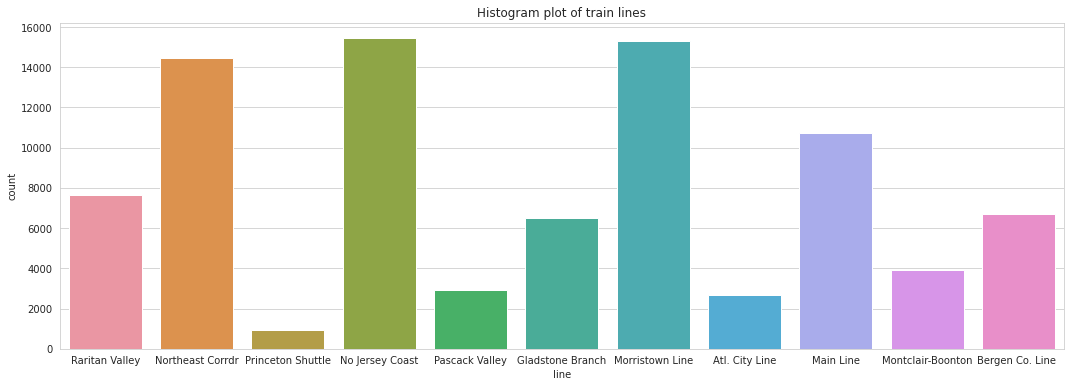

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(x ='line', data = df)
plt.title("Histogram plot of train lines")

####Majority of train lines are coming from the Northeastern Corridor, North Jersey Coast, Morristown line lines.

####Histogram plot

Text(0.5, 1.0, 'Histogram plot of train status')

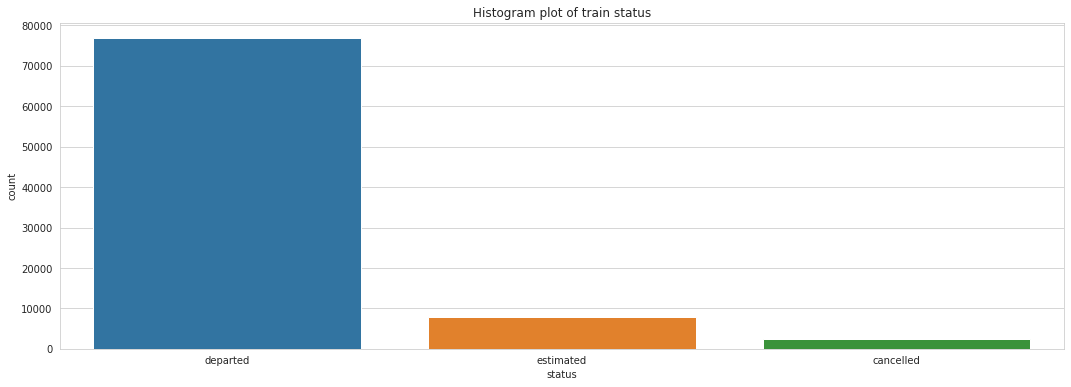

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(x ='status', data = df)
plt.title("Histogram plot of train status")

####Most of the trains departed. Estimated status means trains that actually departed but may be running late. Cancelled status indicates trains that have been cancelled. 

####Distribution plot

Text(0.5, 1.0, 'Distribution of delay minutes')

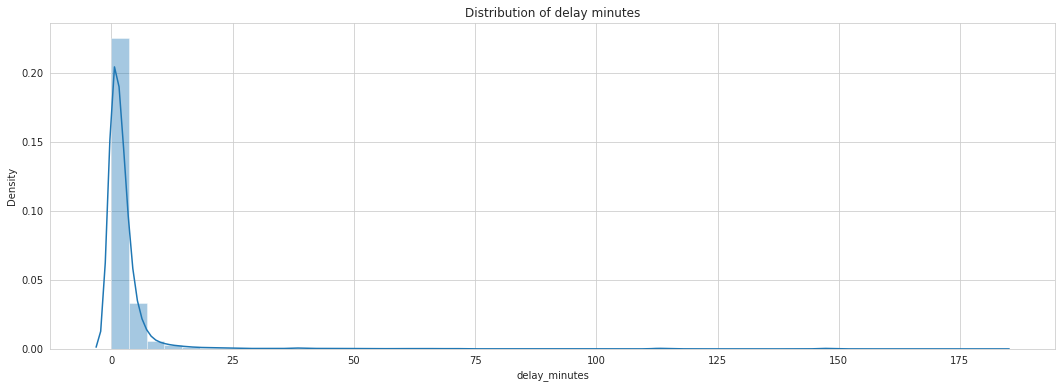

In [ ]:
plt.figure(figsize=(18,6))
sns.distplot(df['delay_minutes'])
plt.title("Distribution of delay minutes")

####Heat Map

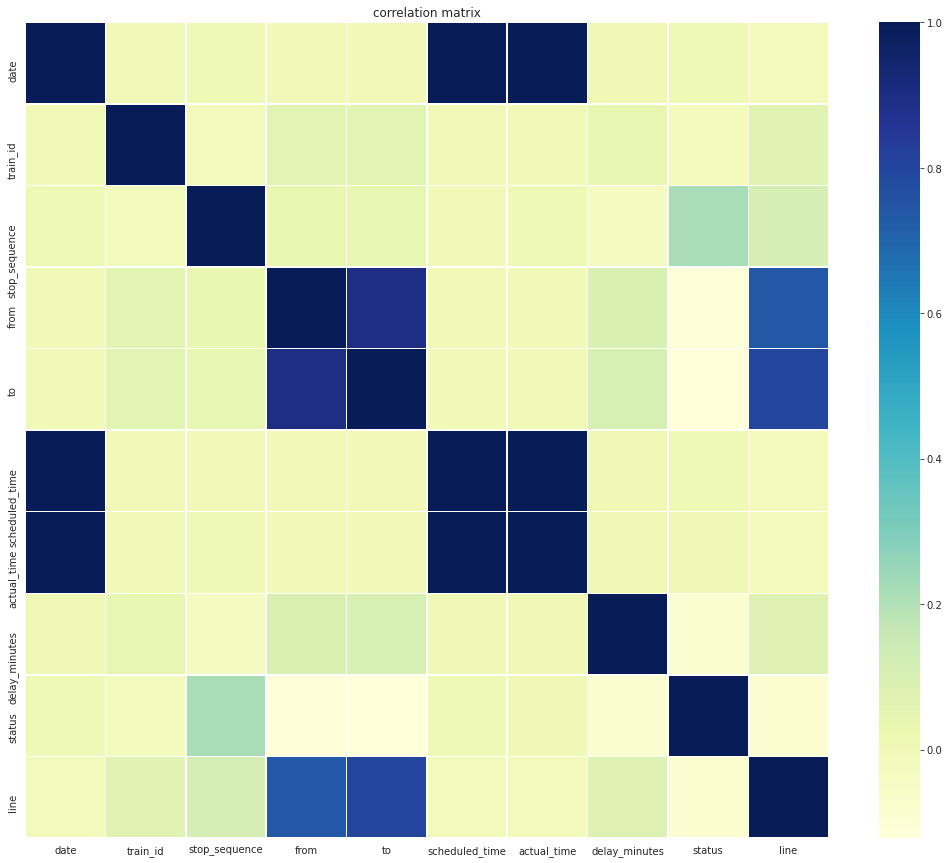

In [ ]:
# create the correlation matrices for multiple categorical variables using pd.factorize
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,15))

plt.plot(1,1)
# draw the heatmap using seaborn.
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.5, cmap="YlGnBu")
plt.title("correlation matrix")

plt.show()

###Feature Engineering


In [ ]:
# Drop the scheduled time, actual time and date columns since we are most interested in the amount of delay which is measured in the delay feature.
df = df.drop(columns='scheduled_time')
df = df.drop(columns='actual_time')
df = df.drop(columns='date')

# Create a feature for delay minutes to indicate if a train is late or not, we will use a threshold of 10 minutes.
df['late'] = df['delay_minutes']>10

# Now we can drop our delay column as we have extracted the necessary information from it.
df = df.drop(columns='delay_minutes')

# Convert categorical variables into dummy variables
df = pd.get_dummies(df, columns={'from','to','line','train_id','status','late'})

In [ ]:
# Normalize the data. Standardize to bring all features to the same scale i.e. mean to zero and the standard deviation to 1.
scaler = StandardScaler()
scaler.fit(df)
X_std = scaler.transform(df)
df_norm = pd.DataFrame(X_std, columns=df.columns)
df_norm.head()

,stop_sequence,train_id_0069,train_id_0070,train_id_0071,train_id_0072,train_id_0073,train_id_0074,train_id_0075,train_id_0076,train_id_0077,train_id_0078,train_id_0079,train_id_0080,train_id_0081,train_id_0082,train_id_0093,train_id_0094,train_id_0509,train_id_0510,train_id_0513,train_id_0514,train_id_0515,train_id_0518,train_id_0519,train_id_0522,train_id_0523,train_id_0526,train_id_0527,train_id_0530,train_id_0531,train_id_0534,train_id_0535,train_id_0538,train_id_0539,train_id_0544,train_id_0545,train_id_0710,train_id_0711,train_id_0712,train_id_0713,...,from_Radburn Fair Lawn,from_Rahway,from_Ramsey Main St,from_Ramsey Route 17,from_Raritan,from_Red Bank,from_Ridgewood,from_River Edge,from_Roselle Park,from_Rutherford,from_Salisbury Mills-Cornwall,from_Secaucus Lower Lvl,from_Secaucus Upper Lvl,from_Short Hills,from_Sloatsburg,from_Somerville,from_South Amboy,from_South Orange,from_Spring Lake,from_Spring Valley,from_Stirling,from_Suffern,from_Summit,from_Teterboro,from_Towaco,from_Trenton,from_Tuxedo,from_Union,from_Upper Montclair,from_Waldwick,from_Walnut Street,from_Watchung Avenue,from_Watsessing Avenue,from_Wayne-Route 23,from_Wesmont,from_Westfield,from_Westwood,from_Wood Ridge,from_Woodbridge,from_Woodcliff Lake
0,-1.413841,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,-0.042341,-0.042341,-0.040536,...,-0.074332,-0.115979,-0.085116,-0.086406,-0.081842,-0.088008,-0.112422,-0.043811,-0.081913,-0.074332,-0.05522,-0.126314,-0.173732,-0.101332,-0.05522,-0.081913,-0.088008,-0.101332,-0.064844,-0.046737,-0.073627,-0.09094,-0.12304,-0.01946,-0.028145,-0.117944,-0.05522,-0.081913,-0.033204,-0.108971,-0.038497,-0.038497,-0.068911,-0.028145,-0.070078,-0.076713,-0.043811,-0.043811,-0.065288,-0.01946
1,-1.213208,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,-0.042341,-0.042341,-0.040536,...,-0.074332,-0.115979,-0.085116,-0.086406,-0.081842,-0.088008,-0.112422,-0.043811,-0.081913,-0.074332,-0.05522,-0.126314,-0.173732,-0.101332,-0.05522,-0.081913,-0.088008,-0.101332,-0.064844,-0.046737,-0.073627,-0.09094,-0.12304,-0.01946,-0.028145,-0.117944,-0.05522,-0.081913,-0.033204,-0.108971,-0.038497,-0.038497,-0.068911,-0.028145,-0.070078,-0.076713,-0.043811,-0.043811,-0.065288,-0.01946
2,-1.012575,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,-0.042341,-0.042341,-0.040536,...,-0.074332,-0.115979,-0.085116,-0.086406,-0.081842,-0.088008,-0.112422,-0.043811,-0.081913,-0.074332,-0.05522,-0.126314,-0.173732,-0.101332,-0.05522,-0.081913,-0.088008,-0.101332,-0.064844,-0.046737,-0.073627,-0.09094,-0.12304,-0.01946,-0.028145,-0.117944,-0.05522,12.208107,-0.033204,-0.108971,-0.038497,-0.038497,-0.068911,-0.028145,-0.070078,-0.076713,-0.043811,-0.043811,-0.065288,-0.01946
3,-0.811942,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,-0.064396,-0.05188,-0.04984,-0.067553,-0.072035,-0.038943,-0.038943,-0.023472,-0.033889,-0.032856,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.033889,-0.032856,-0.017925,-0.032856,-0.033889,-0.032856,-0.033889,-0.033889,-0.024897,-0.032856,-0.042341,-0.042341,

####Applying K-Means Clustering to PCA 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(df_norm)

In [ ]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    pca_components,
    test_size=0.5,
    random_state=42)

In [ ]:
ypred=pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 10.
    for nclust in range(2, 10):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

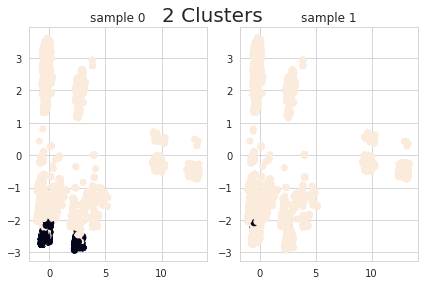

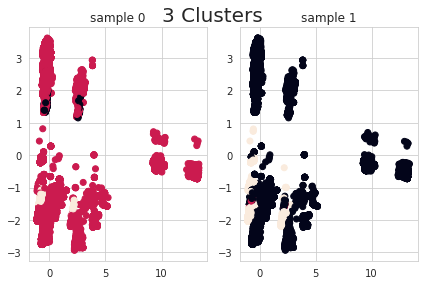

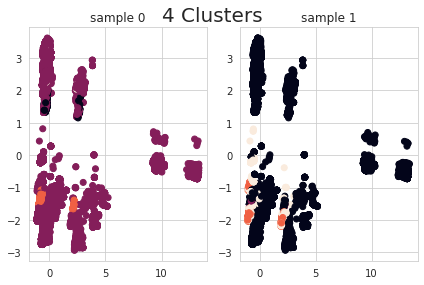

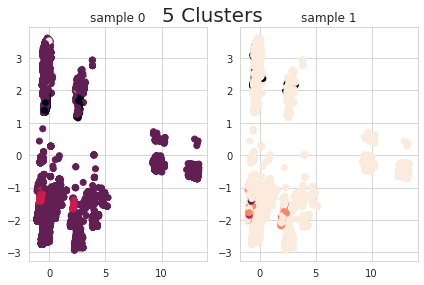

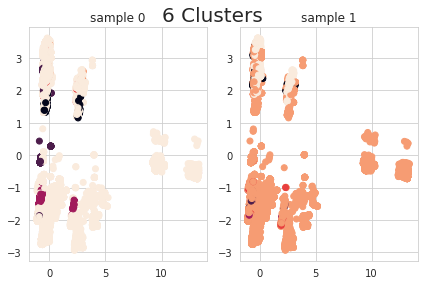

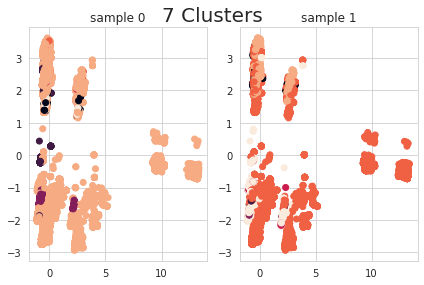

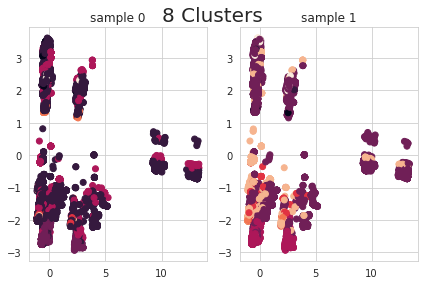

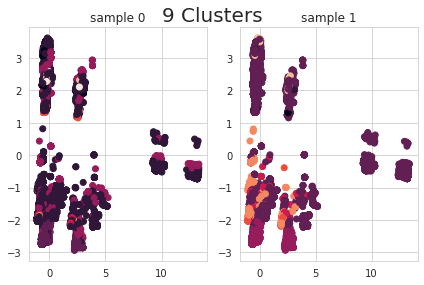

In [ ]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 10):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

####From the PCA plots, some delineation between the clusters can be seen. Ignoring the colors, consistency seems slightly better for 3 and 4 clusters.

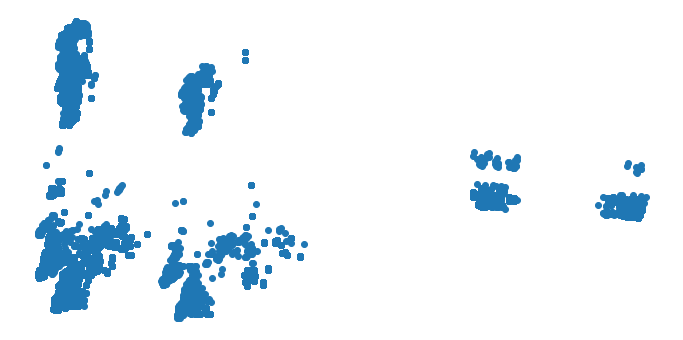

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

####Without the color codes, it is hard to see distinctions between the clusters

####Find optimum number of clusters using PCA 

In [ ]:
from sklearn.cluster import KMeans

# Let's find the optimal number of clusters using the Elbow method
PCA_components = pd.DataFrame(pca_components)

wcss = []
for i in range(1,11):
    # Create a KMeans model with k clusters
    kmeans = KMeans(n_clusters=i)
    
    # Fit model to samples
    kmeans.fit(PCA_components.iloc[:,:3])
    
    # Append the wcss (inertia) to the lis
    wcss.append(kmeans.inertia_)

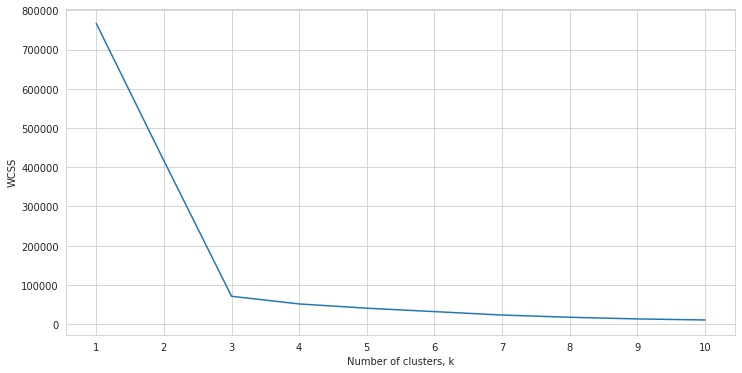

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss)
plt.xticks(np.arange(1,11,step=1))
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')
plt.show()

####From the plot, it looks like the optimal number of clusters is 3

####Silhoutte Coefficient

In [ ]:
from sklearn import metrics

#####n_clusters=2

In [ ]:
pred_2 = KMeans(n_clusters=2, random_state=42).fit_predict(PCA_components)
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_2, metric='euclidean')))

Silhouette score for two cluster k-means: 0.7855666409338029


#####n_clusters=3

In [ ]:
pred_3 = KMeans(n_clusters=3, random_state=42).fit_predict(PCA_components)
print("Silhouette score for three cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_3, metric='euclidean')))

Silhouette score for three cluster k-means: 0.7905561038734719


#####n_clusters=4

In [ ]:
pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(PCA_components)
print("Silhouette score for four cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_4, metric='euclidean')))

Silhouette score for four cluster k-means: 0.7982361091091005


n_clusters=5

In [ ]:
pred_5 = KMeans(n_clusters=5, random_state=42).fit_predict(PCA_components)
print("Silhouette score for five cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_5, metric='euclidean')))

Silhouette score for five cluster k-means: 0.6892778766711531


n_clusters=6

In [ ]:
pred_6 = KMeans(n_clusters=6, random_state=42).fit_predict(PCA_components)
print("Silhouette score for six cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_6, metric='euclidean')))

Silhouette score for six cluster k-means: 0.6268369191765863


#####n_clusters=7

In [ ]:
pred_7 = KMeans(n_clusters=7, random_state=42).fit_predict(PCA_components)
print("Silhouette score for seven cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_7, metric='euclidean')))

Silhouette score for seven cluster k-means: 0.6784334719603506


#####n_clusters=8

In [ ]:
pred_8 = KMeans(n_clusters=8, random_state=42).fit_predict(PCA_components)
print("Silhouette score for eight cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_8, metric='euclidean')))

Silhouette score for eight cluster k-means: 0.6696848511878541


n_clusters=9

In [ ]:
pred_9 = KMeans(n_clusters=9, random_state=42).fit_predict(PCA_components)
print("Silhouette score for nine cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_9, metric='euclidean')))

Silhouette score for nine cluster k-means: 0.5553992455412498


n_clusters=10

In [ ]:
pred_10 = KMeans(n_clusters=10, random_state=42).fit_predict(PCA_components)
print("Silhouette score for ten cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_10, metric='euclidean')))

Silhouette score for ten cluster k-means: 0.5663611717704604


####From the results, Silhoutte scores for n_clusters=4:  0.80 is the highest. Let's use n_clusters=4 for application.

#### Fit the k-means with the best silhouette score using PCA method and time it.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit model.
%timeit kmeans.fit(PCA_components)
y_pred = kmeans.predict(PCA_components)

1 loop, best of 3: 986 ms per loop


####It took 986 ms to train the K-Means model with PCA 

###Apply K-Means Clustering to t-SNE

####Let's fine-tune the hyper parameters. Try a range of Perplexity values from 50 to 100, n_components =2, and n_iter = 1000.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.060s...
[t-SNE] Computed neighbors for 87172 samples in 4.956s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

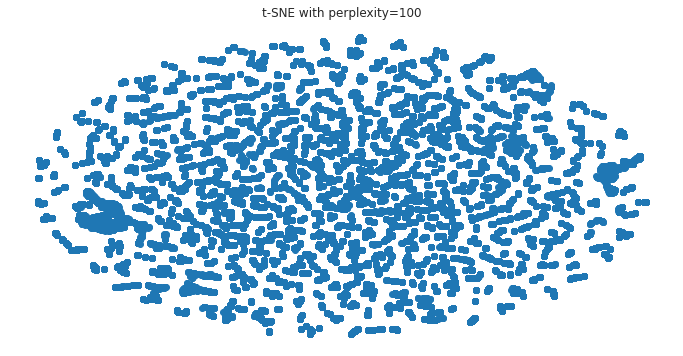

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=100")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.048s...
[t-SNE] Computed neighbors for 87172 samples in 4.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

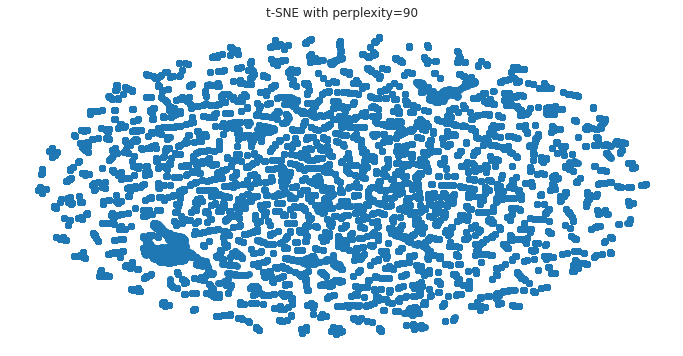

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=90")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.049s...
[t-SNE] Computed neighbors for 87172 samples in 3.869s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

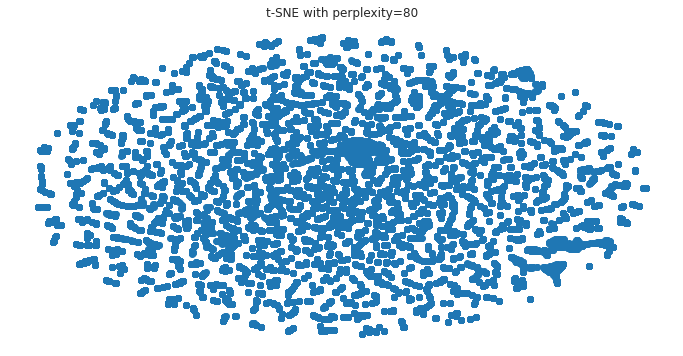

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=80")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.051s...
[t-SNE] Computed neighbors for 87172 samples in 3.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

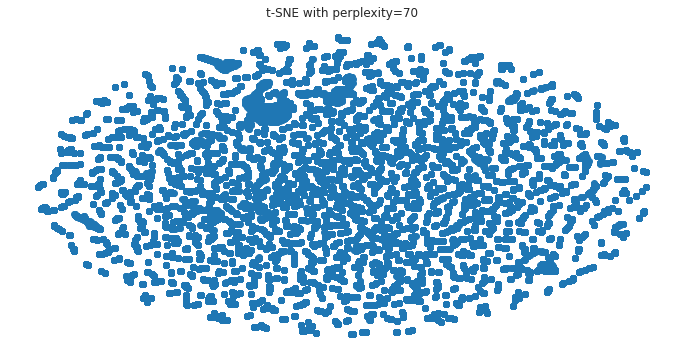

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=70")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.058s...
[t-SNE] Computed neighbors for 87172 samples in 2.877s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

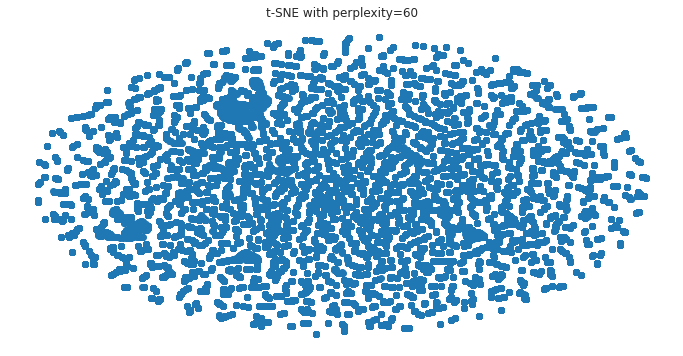

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=60")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.047s...
[t-SNE] Computed neighbors for 87172 samples in 2.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

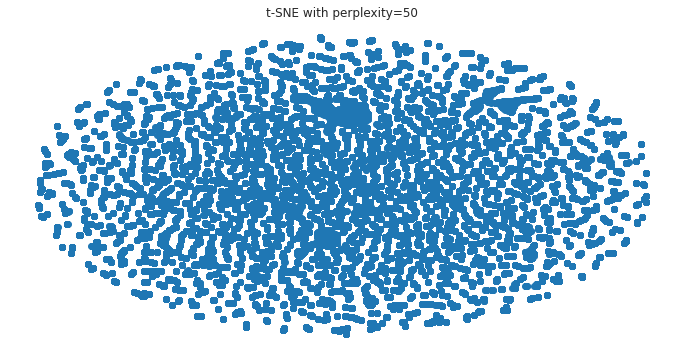

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=50")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

####Different configurations of perplexity in t-SNE achieves different results than PCA. However choosing one of them isn't that much easy by just looking at unlabeled and uncolored graphs. Based on my interpretation, I would pick t-SNE results for Perplexity=90 and apply K-Means clustering.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.050s...
[t-SNE] Computed neighbors for 87172 samples in 4.884s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

In [ ]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_tsnehalf1, X_tsnehalf2 = train_test_split(
    X_std,
    tsne_results,
    test_size=0.5,
    random_state=42)

In [ ]:
ypred=pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the t-SNE derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# t-SNE solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_tsnehalf1),
    (X_half2, X_tsnehalf2)]):
    
    # Put the features into ypred.
    ypred['tsne_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['tsne_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 10.
    for nclust in range(2, 10):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

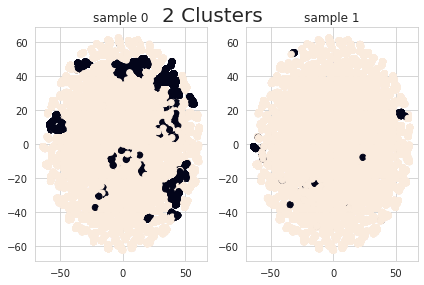

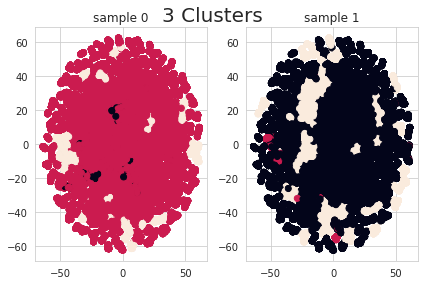

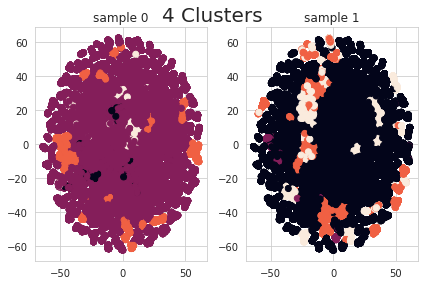

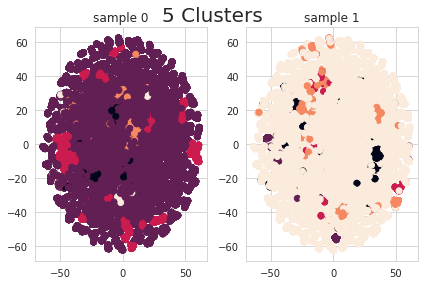

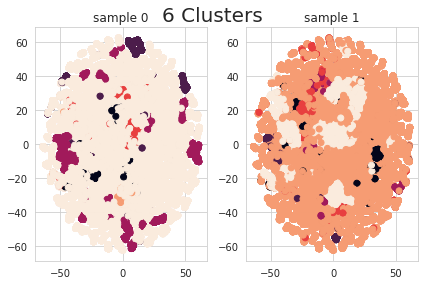

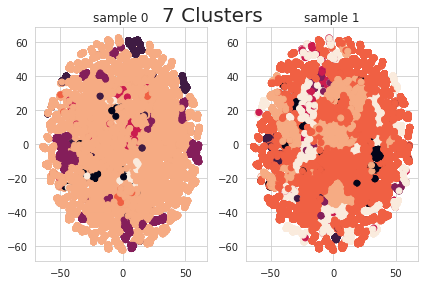

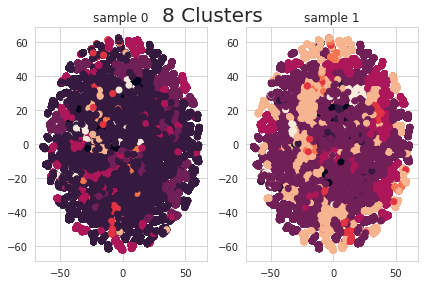

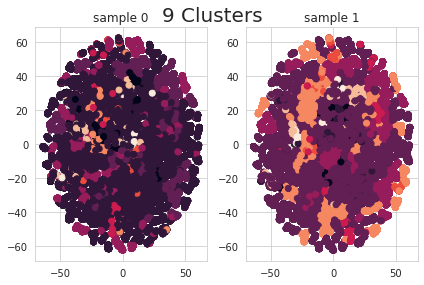

In [ ]:
# For each  number of clusters, plot the clusters using the
# t-SNE features for each sample.
for cluster in range(2, 10):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['tsne_f1_sample{}'.format(i)]
        y_sub = ypred['tsne_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

####From the t-SNE plots, It is hard to see distinction between the clusters. Even ignoring the colors, consistency seems hard to predict. Apply K-means to PCA fetched better results.

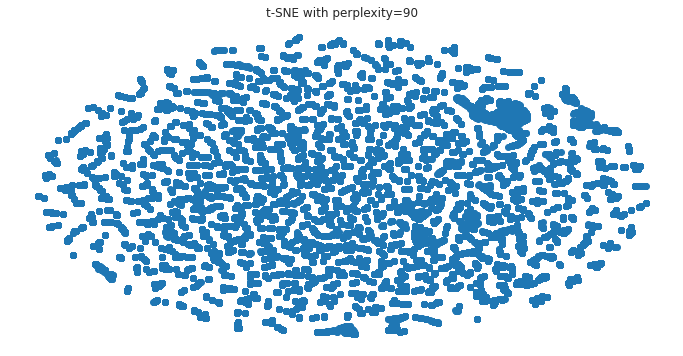

In [ ]:
plt.figure(figsize=(12,6))
plt.title("t-SNE with perplexity=90")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

####Without the color codes, it is even more harder to see distinctions between the clusters

###Find the optimum number of clusters using t-SNE

In [ ]:
from sklearn.cluster import KMeans

# Let's find the optimal number of clusters using the Elbow method
tsne_components = pd.DataFrame(tsne_results)

wcss = []
for i in range(1,11):
    # Create a KMeans model with k clusters
    kmeans = KMeans(n_clusters=i)
    
    # Fit model to samples
    kmeans.fit(tsne_components.iloc[:,:3])
    
    # Append the wcss (inertia) to the lis
    wcss.append(kmeans.inertia_)

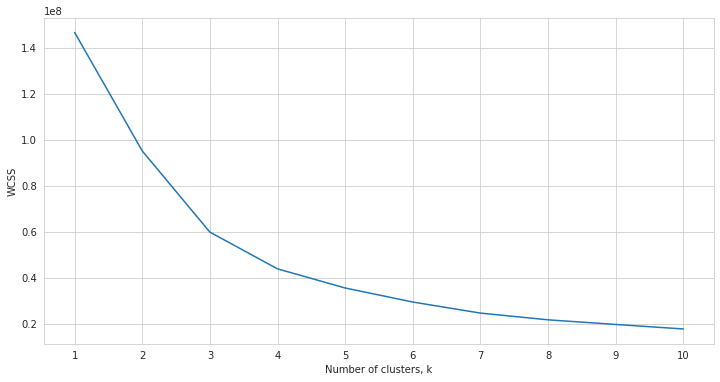

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss)
plt.xticks(np.arange(1,11,step=1))
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')
plt.show()

####Based on this elbow plot, it's hard to determine the optimum number of clusters using t-SNE results.

####Silhoutte coefficient for n_clusters 2 to 10 based on t-SNE results

In [ ]:
pred_2 = KMeans(n_clusters=2, random_state=42).fit_predict(tsne_results)
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_2, metric='euclidean')))

Silhouette score for two cluster k-means: 0.33199939131736755


In [ ]:
pred_3 = KMeans(n_clusters=3, random_state=42).fit_predict(tsne_results)
print("Silhouette score for three cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_3, metric='euclidean')))

Silhouette score for three cluster k-means: 0.3628472685813904


In [ ]:
pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(tsne_results)
print("Silhouette score for four cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_4, metric='euclidean')))

Silhouette score for four cluster k-means: 0.3486056327819824


In [ ]:
pred_5 = KMeans(n_clusters=5, random_state=42).fit_predict(tsne_results)
print("Silhouette score for five cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_5, metric='euclidean')))

Silhouette score for five cluster k-means: 0.3283984959125519


In [ ]:
pred_6 = KMeans(n_clusters=6, random_state=42).fit_predict(tsne_results)
print("Silhouette score for six cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_6, metric='euclidean')))

Silhouette score for six cluster k-means: 0.3563532829284668


In [ ]:
pred_7 = KMeans(n_clusters=7, random_state=42).fit_predict(tsne_results)
print("Silhouette score for seven cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_7, metric='euclidean')))

Silhouette score for seven cluster k-means: 0.35336145758628845


In [ ]:
pred_8 = KMeans(n_clusters=8, random_state=42).fit_predict(tsne_results)
print("Silhouette score for eight cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_8, metric='euclidean')))

Silhouette score for eight cluster k-means: 0.3421407639980316


In [ ]:
pred_9 = KMeans(n_clusters=9, random_state=42).fit_predict(tsne_results)
print("Silhouette score for nine cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_9, metric='euclidean')))

Silhouette score for nine cluster k-means: 0.33962759375572205


In [ ]:
pred_10 = KMeans(n_clusters=10, random_state=42).fit_predict(tsne_results)
print("Silhouette score for ten cluster k-means: {}".format(metrics.silhouette_score(tsne_results, pred_10, metric='euclidean')))

Silhouette score for ten cluster k-means: 0.33255326747894287


####From the results, Silhoutte scores using t-SNE is 0.35 compared to Silhoutte score using PCA is 0.80 (for n_clusters=4). 

####Fit the k-means with n_clusters=4 silhouette score for t-SNE results and time it.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit model.
%timeit kmeans.fit(tsne_results)
y_pred = kmeans.predict(tsne_results)

1 loop, best of 3: 730 ms per loop


####It took 730 ms to train the K-Means model with t-SNE

####In conclusion, the clustering performance with K-Means clustering using PCA with a silhoutte score of 0.8 is much better than K-Means clustering using t-SNE with a silhoutte score of 0.35. 

###Apply DBSCAN clustering to PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(df_norm)

####Let's fine-tune the hyper parameters eps ranging from 0.01 to 0.3 and min_samples ranging from 1 to 100. Note. Kernel crashed multiple times when running with eps>0.3 after using all available RAM.

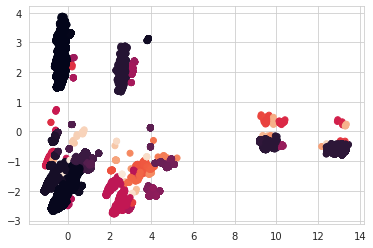

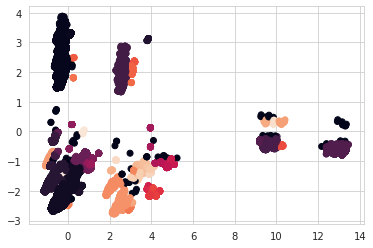

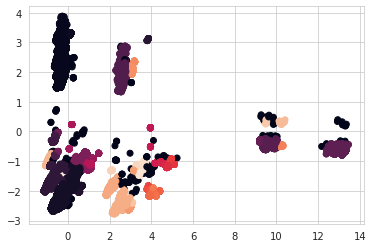

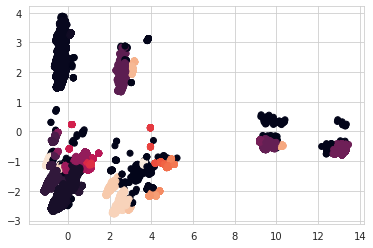

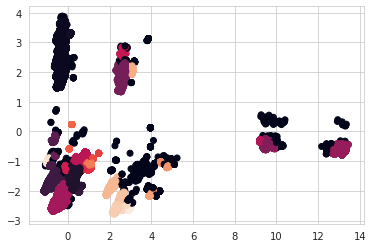

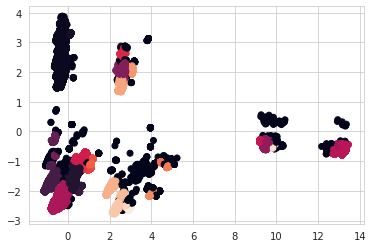

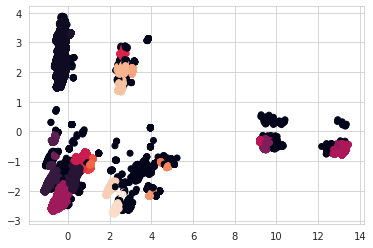

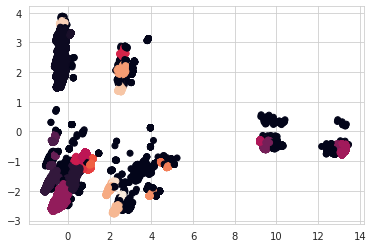

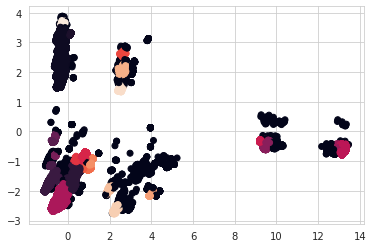

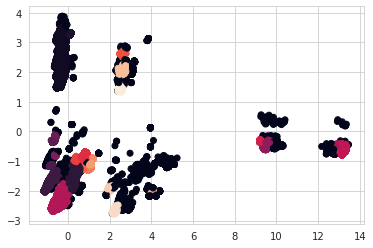

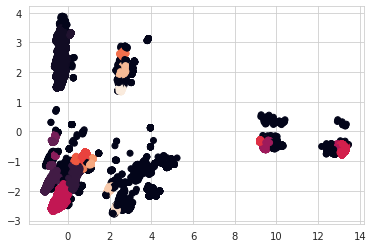

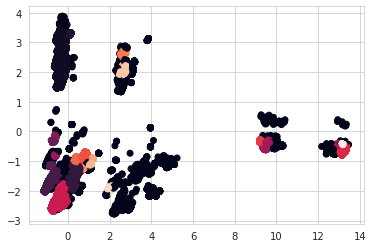

In [ ]:
from sklearn.cluster import DBSCAN

for k in [1,5,10,20,30,40,50,60,70,80,90,100]:
  # Defining the agglomerative clustering
  dbscan_cluster = DBSCAN(eps=0.1, min_samples=k, metric='euclidean')

  # Fit model
  clusters = dbscan_cluster.fit_predict(pca_components)

  # Plot the solution.
  plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters)
  plt.show()

Looking at the cluster blobs, we can see that number of clusters increases as min_samples decreases. 

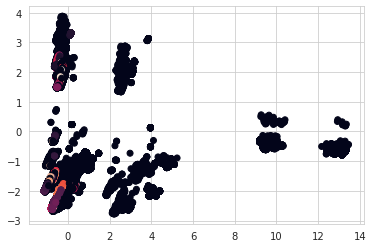

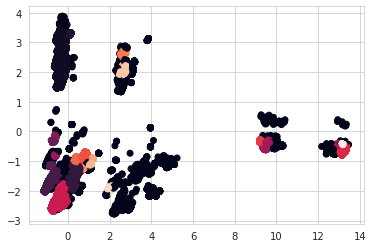

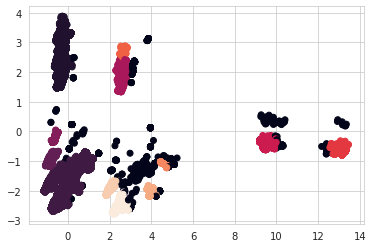

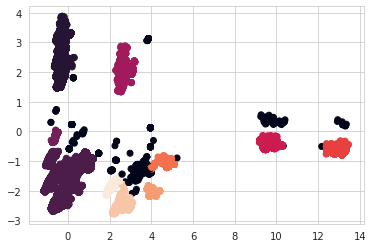

In [ ]:
for k in [0.01,0.1,0.2,0.3]:
  # Defining the agglomerative clustering
  dbscan_cluster = DBSCAN(eps=k, min_samples=100, metric='euclidean')

  # Fit model
  clusters = dbscan_cluster.fit_predict(pca_components)

  # Plot the solution.
  plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters)
  plt.show()

####Looking at the cluster blobs, we can see that number of clusters increases as eps increases. 

####Let's fit DBSCAN cluster to PCA using our best guess hyperparameters eps=0.3, min_samples=10

In [ ]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=10, metric='euclidean')
clusters = dbscan_cluster.fit_predict(pca_components)
print("The silhouette score for DBSCAN clustering: {}".format(metrics.silhouette_score(pca_components, clusters, metric='euclidean')))

The silhouette score for DBSCAN clustering: 0.594993906377313


####Silhoutte score using DBSCAN clustering to PCA is 0.59 compared to K-Means clustering is 0.80. K-means clustering performance is better. 

###Apply DBSCAN Clustering to t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.051s...
[t-SNE] Computed neighbors for 87172 samples in 4.584s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

In [ ]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=10, metric='euclidean')
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score for DBSCAN clustering: {}".format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score for DBSCAN clustering: 0.8434002995491028


####Silhoutte score using DBSCAN clustering to t-SNE is 0.84 compared to K-Means clustering is 0.35. DBSCAN clustering performance is much better based on these results. But looking at the cluster blobs, it's hard to find optimum numbers of clusters for our analysis. 

###Application of K-Means clustering for our business solution

####Create a copy of original dataframe and applying K-means clusters labels

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/2020_05.csv')

In [ ]:
df1 = df1.drop(columns='to_id')
df1 = df1.drop(columns='from_id')
df1 = df1.drop(columns='type')

In [ ]:
df1 = df1.dropna()

In [ ]:
# Drop the scheduled time, actual time and date columns since we are most interested in the amount of delay which is measured in the delay feature.
df1 = df1.drop(columns='scheduled_time')
df1 = df1.drop(columns='actual_time')
df1 = df1.drop(columns='date')

# Create a feature for delay minutes to indicate if a train is late or not, we will use a threshold of 10 minutes.
df1['late'] = df1['delay_minutes']>10

# Now we can drop our delay column as we have extracted the necessary information from it.
df1 = df1.drop(columns='delay_minutes')

In [ ]:
df1.head()

,train_id,stop_sequence,from,to,status,line,late
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False


In [ ]:
# Attach the cluster labels to the data frame
df1['cluster'] = kmeans.labels_

In [ ]:
#Look at the dataframe with the cluster labels attached
df1.head()

,train_id,stop_sequence,from,to,status,line,late,cluster
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False,3
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False,3
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False,3
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False,3
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False,3


####Cluster into 4 groups and answer the business question which cluster contains train lines that are late and not late. 

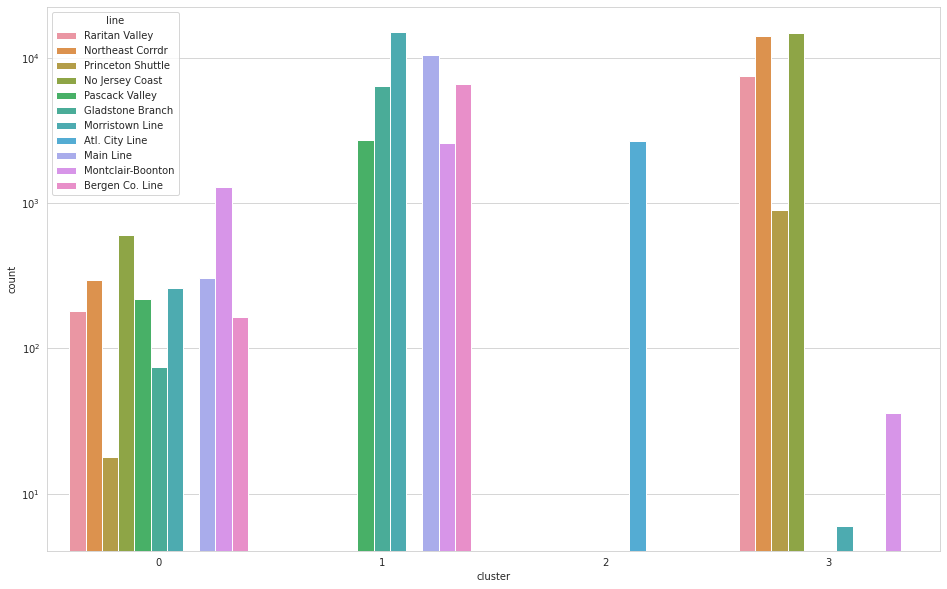

In [ ]:
plt.figure(figsize=(16,10))
g = sns.countplot(x='cluster',hue='line',data=df1)
g.set_yscale('log')

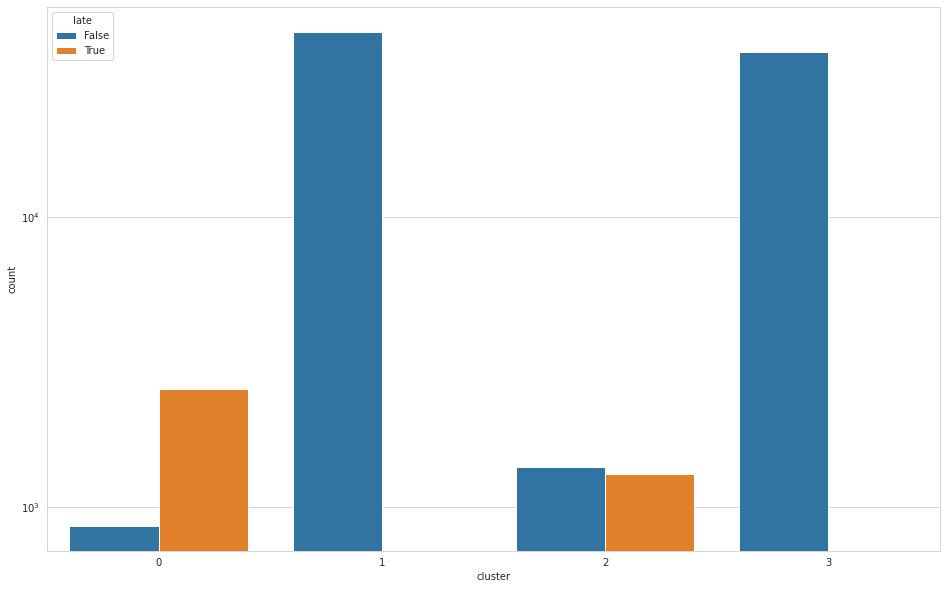

In [ ]:
plt.figure(figsize=(16,10))
g = sns.countplot(x='cluster',hue='late',data=df1)
g.set_yscale('log')

#### Cluster 0 contains (10 out of 11) train lines that are mostly late and very few train lines that aren't late. Cluster 1 contains (6 out of 11) train lines that are exclusively not late. Cluster 2 contains only one train line that has almost equal late and not late trains. Cluster 3 contains (6 out of 11) train lines that are exclusively not late. In conclusion, it looks like train lines in Cluster 0 and Cluster 2 groups are mostly in need of fix to avoid potential delays and address customer complaints. 

###Application of DBSCAN clustering for our business solution

In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/2020_05.csv')

In [ ]:
df2 = df2.drop(columns='to_id')
df2 = df2.drop(columns='from_id')
df2 = df2.drop(columns='type')

In [ ]:
df2 = df2.dropna()

In [ ]:
# Drop the scheduled time, actual time and date columns since we are most interested in the amount of delay which is measured in the delay feature.
df2 = df2.drop(columns='scheduled_time')
df2 = df2.drop(columns='actual_time')
df2 = df2.drop(columns='date')

# Create a feature for delay minutes to indicate if a train is late or not, we will use a threshold of 10 minutes.
df2['late'] = df2['delay_minutes']>10

# Now we can drop our delay column as we have extracted the necessary information from it.
df2 = df2.drop(columns='delay_minutes')

In [ ]:
df2.head()

,train_id,stop_sequence,from,to,status,line,late
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.056s...
[t-SNE] Computed neighbors for 87172 samples in 5.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

In [ ]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=10, metric='euclidean')
clusters = dbscan_cluster.fit_predict(tsne_results)
print("The silhouette score for DBSCAN clustering: {}".format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score for DBSCAN clustering: 0.8365049958229065


In [ ]:
# Attach the cluster labels to the data frame
df2['cluster'] = dbscan_cluster.labels_

In [ ]:
#Look at the dataframe with the cluster labels attached
df2.head()

,train_id,stop_sequence,from,to,status,line,late,cluster
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False,0
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False,1
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False,-1
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False,2
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False,-1


In [ ]:
np.unique(clusters)

array([  -1,    0,    1, ..., 2291, 2292, 2293])

####It is difficult to apply DBSCAN clustering for our business solution as we have 2293 unique clusters. It can be feasible if we had fewer clusters to target. 

###Application of GMM clustering for our business solution

In [ ]:
df3 = pd.read_csv('/content/drive/My Drive/2020_05.csv')

In [ ]:
df3 = df3.drop(columns='to_id')
df3 = df3.drop(columns='from_id')
df3 = df3.drop(columns='type')

In [ ]:
df3 = df3.dropna()

In [ ]:
# Drop the scheduled time, actual time and date columns since we are most interested in the amount of delay which is measured in the delay feature.
df3 = df3.drop(columns='scheduled_time')
df3 = df3.drop(columns='actual_time')
df3 = df3.drop(columns='date')

# Create a feature for delay minutes to indicate if a train is late or not, we will use a threshold of 10 minutes.
df3['late'] = df3['delay_minutes']>10

# Now we can drop our delay column as we have extracted the necessary information from it.
df3 = df3.drop(columns='delay_minutes')

In [ ]:
df3.head()

,train_id,stop_sequence,from,to,status,line,late
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.089s...
[t-SNE] Computed neighbors for 87172 samples in 4.900s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for sa

In [ ]:
from sklearn.mixture import GaussianMixture

gmm_cluster2 = GaussianMixture(n_components=2, random_state=42, covariance_type="spherical")
clusters_2 = gmm_cluster2.fit_predict(tsne_results)
print("The silhouette score for GMM cluster 2: {}".format(metrics.silhouette_score(tsne_results, clusters_2, metric='euclidean')))

The silhouette score for GMM cluster 2: 0.3315265476703644


In [ ]:
gmm_cluster3 = GaussianMixture(n_components=3, random_state=42, covariance_type="spherical")
clusters_3 = gmm_cluster3.fit_predict(tsne_results)
print("The silhouette score for GMM cluster 3: {}".format(metrics.silhouette_score(tsne_results, clusters_3, metric='euclidean')))

The silhouette score for GMM cluster 3: 0.36095860600471497


In [ ]:
gmm_cluster4 = GaussianMixture(n_components=4, random_state=42, covariance_type="spherical")
clusters_4 = gmm_cluster4.fit_predict(tsne_results)
print("The silhouette score for GMM cluster 4: {}".format(metrics.silhouette_score(tsne_results, clusters_4, metric='euclidean')))

The silhouette score for GMM cluster 4: 0.347258597612381


In [ ]:
gmm_cluster5 = GaussianMixture(n_components=5, random_state=42, covariance_type="spherical")
clusters_5 = gmm_cluster5.fit_predict(tsne_results)
print("The silhouette score for GMM cluster 5: {}".format(metrics.silhouette_score(tsne_results, clusters_5, metric='euclidean')))

The silhouette score for GMM cluster 5: 0.32635462284088135


In [ ]:
gmm_cluster6 = GaussianMixture(n_components=6, random_state=42, covariance_type="spherical")
clusters_6 = gmm_cluster6.fit_predict(tsne_results)
print("The silhouette score for GMM cluster 6: {}".format(metrics.silhouette_score(tsne_results, clusters_6, metric='euclidean')))

The silhouette score for GMM cluster 6: 0.28701671957969666


####GMM clustering silhouette scores ranging from 0.28 to .36 for clusters ranging from 2 to 6. Let's pick n_components=4 for cluster analysis.

In [ ]:
gmm_cluster4 = GaussianMixture(n_components=4, random_state=42, covariance_type="spherical")
clusters_4 = gmm_cluster4.fit_predict(tsne_results)

In [ ]:
df3 = df3.drop(columns='cluster')

In [ ]:
df3 = pd.concat([df3.reset_index(drop=True),pd.Series(clusters_4)],axis=1)

In [ ]:
df3.rename({0: 'clusters_4'},axis='columns',inplace=True)

In [ ]:
df3.head()

,train_id,stop_sequence,from,to,status,line,late,clusters_4
0,5543,1.0,Newark Penn Station,Newark Penn Station,departed,Raritan Valley,False,3
1,5543,2.0,Newark Penn Station,Union,departed,Raritan Valley,False,1
2,5543,3.0,Union,Roselle Park,departed,Raritan Valley,False,1
3,5543,4.0,Roselle Park,Cranford,departed,Raritan Valley,False,1
4,5543,5.0,Cranford,Westfield,departed,Raritan Valley,False,1


In [ ]:
np.unique(clusters_4)

array([0, 1, 2, 3])

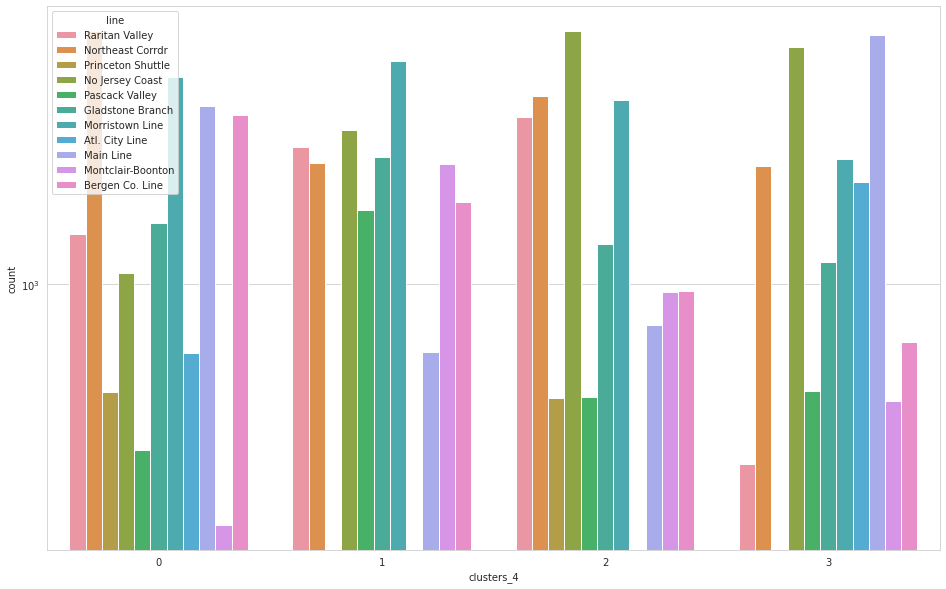

In [ ]:
plt.figure(figsize=(16,10))
g = sns.countplot(x='clusters_4',hue='line',data=df3)
g.set_yscale('log')

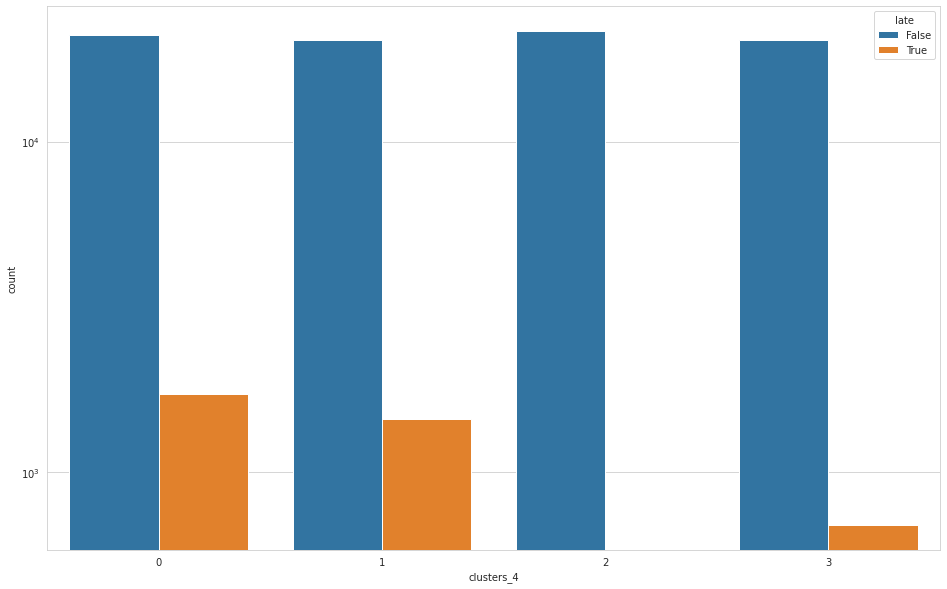

In [ ]:
plt.figure(figsize=(16,10))
g = sns.countplot(x='clusters_4',hue='late',data=df3)
g.set_yscale('log')

####Cluster 0 contains (11 out of 11) train lines that are mostly non-late and some lines that are late. Cluster 1 contains (9 out of 11) train lines that are mostly non-late and some lines that are late. Cluster 2 contains (10 out of 11) train lines that are exclusively non-late. Cluster 3 contains (10 out of 11) train lines that are mostly not late and very few late trains. In conclusion, it looks like train lines in Cluster 0 and Cluster 1 groups are mostly in need of fix to avoid potential delays and address customer complaints.

#### In conclusion, I have applied Unsupervised Learning (KMeans, DBSCAN and GMM clustering) and dimensionality reduction techniques (PCA, t-SNE) to group similar observations and gain valuable insights from NJ Transit + Amtrak (NEC) Rail Performance Dataset. This helped in identifying train lines that are in need of fix to avoid potential delays and address customer complaints. 

#### We see the best performance with KMeans clustering using PCA with a silhouette score of 0.8. We were able to segment the train lines into 4 clusters based on if they are going to be late or not and implemented the model to our business solution. We see even better performance with DBSCAN clustering using t-SNE with a silhoutte score of 0.84. But it's hard to find feasible number of clusters to target and analyze the model in our application. GMM clustering with t-SNE has a silhoutte score of 0.34 which is much lower compared to K-means and DBSCAN clustering. Compared to DBSCAN, GMM clustering does a good job of segmenting the train lines into 4 clusters based on late or not for our business solution with a trade-off with silhoutte score. 

####For future work, I can look at applying these different clustering techniques to find how train delays vary at different times during the weekdays and weekends so riders can better plan their transporatation needs ahead of time. Also, I can apply different Supervised Learning algorithms for this classification problem and compare performance to best performing models.